Import Dependencies

In [1]:
from pydantic import BaseModel, Field

from qdrant_client import QdrantClient
from qdrant_client.models import Document, Prefetch, FusionQuery, Filter, FieldCondition, MatchText
from qdrant_client import models

from langsmith import traceable, get_current_run_tree


from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.types import Send, Command

from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.messages import convert_to_openai_messages, convert_to_messages

from jinja2 import Template
from typing import Literal, Dict, Any, Annotated, List, Optional, Sequence
from IPython.display import Image, display
from operator import add
from openai import OpenAI

import openai

import random
import ast
import inspect
import instructor
import json

from utils.utils import  format_ai_message, get_tool_descriptions

/Users/camilo/retrieval_rec_amazon/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
qdrant_client = QdrantClient(url="http://localhost:6333")

In [6]:
def get_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )
    return response.data[0].embedding

In [97]:
def retrieve_data(query, qdrant_client, k=5):

    query_embedding = get_embedding(query)

    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-02-hybrid-search",
        prefetch = [
            Prefetch(
                query= query_embedding,
                using = "text-embedding-3-small",
                limit=20
            ),
            Prefetch(
                query=Document(
                    text=query,
                    model="qdrant/bm25"
                ),
                using = "bm25",
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=k,
    )

    retrieved_context_ids = []
    retrieved_context = []
    similarity_scores = []
    retrieved_context_ratings = []

    for result in results.points:
        retrieved_context_ids.append(result.payload["parent_asin"])
        retrieved_context.append(result.payload["description"])
        retrieved_context_ratings.append(result.payload["average_rating"])
        similarity_scores.append(result.score)

    return {
        "retrieved_context_ids": retrieved_context_ids,
        "retrieved_context": retrieved_context,
        "retrieved_context_ratings": retrieved_context_ratings,
        "similarity_scores": similarity_scores,
    }


In [7]:
def retrieve_data(query, qdrant_client, k=5):

    query_embedding = get_embedding(query)

    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-02-hybrid-search",
        prefetch=[
            Prefetch(
                query=query_embedding,
                using="text-embedding-3-small",
                limit=20
            ),
            Prefetch(
                query=Document(
                    text=query,
                    model="qdrant/bm25"
                ),
                using="bm25",
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=k,
    )

    retrieved_context_ids = []
    retrieved_context = []
    similarity_scores = []
    retrieved_context_ratings = []

    for result in results.points:
        retrieved_context_ids.append(result.payload["parent_asin"])
        retrieved_context.append(result.payload["description"])
        retrieved_context_ratings.append(result.payload["average_rating"])
        similarity_scores.append(result.score)

    return {
        "retrieved_context_ids": retrieved_context_ids,
        "retrieved_context": retrieved_context,
        "retrieved_context_ratings": retrieved_context_ratings,
        "similarity_scores": similarity_scores,
    }

In [82]:
query = "Can i get a tablet"

In [83]:
answer = retrieve_data(query, qdrant_client, k=5)

In [33]:
answer

{'retrieved_context_ids': ['B0B8NVNQKX',
  'B0B6VMB3D1',
  'B0BR33XH8D',
  'B0BN7WWH63',
  'B09LH466KZ'],
 'retrieved_context': ['COOPERS 7 inch Kids Tablet Android 11 Tablet for Kids, 2GB RAM + 32GB ROM Toddler Tablet PC for Children, IPS Touch Screen, Dual Camera, Dual Speaker, WiFi Computer Tablet, Light Blue ✿【Good Kids tablet】This 7 inch tablet for kids with silm body and lightweight, it is easy to hold by children. Also the special design can protect the tablet well when dropping. ✿【Parental Control】Toddlers Tablet with parent mode can add or block apps. Set screen time limits. This tablet come with iwawa app. kids can get access to fun and educational games and videos. ✿【Powerful Tablets】Equipmented with quad core CPU, Android 11.0 System, 32GB Big Storage, 1024*600 IPS Screen offer a clear view. Runs Kinds of apps and game for kids smoothly. ✿【Long Lasting】Tablet for kids built with large capacity battery. For mixed use up to 6 hours. You can enjoy happy parent-child time with 

<h4>Multi Intent Questions</h4>

In [8]:
query = "Can I get a tablet for my kid, a watch for me and a laptop for my wife?"

In [9]:
answer = retrieve_data(query, qdrant_client, k=10)

In [124]:
answer

{'retrieved_context_ids': ['B0BRXZDBXZ',
  'B0BL2CZSHT',
  'B0B8NVNQKX',
  'B0C142QS8X',
  'B0C3XYD574',
  'B0BCQ8RJG7',
  'B0CFFGT7RM',
  'B09XQGN52P',
  'B09Q8FLNDR',
  'B0BFGXRMJN'],
 'retrieved_context': ["Kids Tablet, 7 inch Tablet for Kids 3GB RAM 32GB ROM, Android 11 Toddler Tablet with WiFi, Bluetooth, GMS, Parental Control, Shockproof Case, Google Play, YouTube, Netflix 【iWawa APP with parental control】This kids tablet has passed the GMS certification and is pre-installed with the iwawa app, specially designed for children. It has password control, remote video control, one-button lock screen and Learning, art, smart games. New-upgrade kids online school, fun interaction, video playback 【Android 11.0 & 128 GB Expand】Android 11.0 operating system, 3GB RAM 32GB ROM, support WiFi, Bluetooth, GPS, etc. The HD 1024*600IPS display can offer a perfect experience, You can expand the storage to 128 GB of SD cards for storing photos, music and videos. The upgraded battery can last more 

In [10]:
class QueryExpandResponse(BaseModel):
   statements: List[str]

In [11]:
def query_expand_node(query) ->dict:
    prompt_template =  """You are part of a shopping assistant that can answer questions about products in stock.

Instructions:
- You will be given a question and you need to expand it into a list of statements that can be used in contextual search to retrieve relevant products.
- The statements should not overlap in context.

<Question>
{{ query }}
</Question>
"""

    template = Template(prompt_template)

    prompt = template.render(
        query = query
    )

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model = "gpt-4.1-mini",
        response_model = QueryExpandResponse,
        messages= [{"role": "system", "content": prompt}],
        temperature = 0.5
    )

    return {
        "queries": response.statements
    }

In [15]:
def query_expand_node(query) -> dict:

   prompt_template =  """You are part of a shopping assistant that can answer questions about products in stock.

Instructions:
- You will be given a question and you need to expand it into a list of statements that can be used in contextual search to retrieve relevant products.
- The statements should not overlap in context.

<Question>
{{ query }}
</Question>
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      query=query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=QueryExpandResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "queries": response.statements
   }

In [12]:
query

'Can I get a tablet for my kid, a watch for me and a laptop for my wife?'

In [16]:
answer = query_expand_node(query)

In [17]:
answer

{'queries': ['tablet suitable for kids',
  'watch for adults',
  'laptop for wife']}

<h4> LangGraph </h4>

#### Query Expansion (Sequential Execution)

In [18]:
class QueryExpandResponse(BaseModel):
    expanded_query: List[str]

In [19]:
class State(BaseModel):
    expanded_query: List[str] = []
    retrieved_context: Annotated[List[str], add] = []
    initial_query: str = ""
    answer: str = ""

#### Query Expansion/ Rewriting Node

In [20]:
@traceable(
    name="query_expand_node",
    run_type = "llm",
    metadata = {"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def query_expand_node(state: State) ->dict:
    prompt_template = """You are part of a shopping assistant that can answer questions about products in stock.
    
    Instructions:
    -You will be given a question and you need to expand it into a list of statements that can be used in contextual search to retrieve relevant products.
    -The statements should not overlap in context.
    -Be as concise as possible, do not make up synonyms for statements, one statement per piece of context.

    <Question>
    {{ query }}
    </Question>
    """

    template = Template(prompt_template)

    prompt = template.render(
        query = state.initial_query
    )

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model = "gpt-4.1-mini",
        response_model = QueryExpandResponse,
        messages= [{"role": "system", "content": prompt}],
        temperature = 0.5
    )

    return {
        "expanded_query": response.expanded_query
    }

In [21]:
query = "Can i get a table for my kid, a watch for me and a laptop for my wife?"
initial_state = {
    "initial_query": query
}

#### Retriever Node

In [22]:
@traceable(
    name="embed_query",
    run_type = "embedding",
    metadata = {"ls_provider": "openai", "ls_model_name": "text-embedding-3-small"}
)
def get_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=text,
        model=model,
    )

    return response.data[0].embedding

@traceable(
    name="retrieve_top_n",
    run_type = "retriever",
   
)
def retrieve_data(query,  k=5):
    qdrant_client = QdrantClient(url="http://localhost:6333")

    query_embedding = get_embedding(query)

    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-02-hybrid-search",
        prefetch = [
            Prefetch(
                query= query_embedding,
                using = "text-embedding-3-small",
                limit=20
            ),
            Prefetch(
                query=Document(
                    text=query,
                    model="qdrant/bm25"
                ),
                using = "bm25",
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=k,
    )

    retrieved_context_ids = []
    retrieved_context = []
    similarity_scores = []
    retrieved_context_ratings = []

    for result in results.points:
        retrieved_context_ids.append(result.payload["parent_asin"])
        retrieved_context.append(result.payload["description"])
        retrieved_context_ratings.append(result.payload["average_rating"])
        similarity_scores.append(result.score)

    formatted_context = ""

    for id, chunk, rating in zip(retrieved_context_ids, retrieved_context, retrieved_context_ratings):
        formatted_context += f"- ID: {id}, rating: {rating}, description: {chunk}\n"


    return formatted_context

@traceable(
    name="retrieve_node",
    run_type = "retriever",
)
def retrieve_node(state: State) ->dict:
    retrieved_context = []

    for query in state.expanded_query:
        retrieved_context.append(retrieve_data(query, k=5))

    return {
        "retrieved_context": retrieved_context

    }

    


#### Aggregator Node

In [23]:
class AggregatorResponse(BaseModel):
    answer: str = Field(description="Answer to the question")

In [24]:
@traceable(
    name="aggregator_node",
    run_type = "llm",
    metadata = {"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def aggregator_node(state: State) ->dict:

    preprocessed_context = "\n".join(state.retrieved_context)
    prompt_template = f"""You are  a shopping assistant that can answer questions about products in stock.
    
    Instructions:
    -You need to answer the question based on the provided context only.
   -Never used word context and refer to it as the available products.
   -The answer to the question should contain detailed information about the product and returned with detailed specification in bullet points.

   Context:

   {{ preprocessed_context }}

    Question:
    {{ query }}
    """

    template = Template(prompt_template)

    prompt = template.render(
        preprocessed_context = preprocessed_context,
        query = state.initial_query
    )

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model = "gpt-4.1-mini",
        response_model = AggregatorResponse,
        messages= [{"role": "system", "content": prompt}],
        temperature = 0.5
    )

    return {
        "answer": response.answer
    }

In [25]:
workflow = StateGraph(State)

workflow.add_node("query_expand_node", query_expand_node)
workflow.add_node("retrieve_node", retrieve_node)
workflow.add_node("aggregator_node", aggregator_node)

workflow.add_edge(START, "query_expand_node")
workflow.add_edge("query_expand_node", "retrieve_node")
workflow.add_edge( "retrieve_node", "aggregator_node")
workflow.add_edge("aggregator_node", END)



graph = workflow.compile()

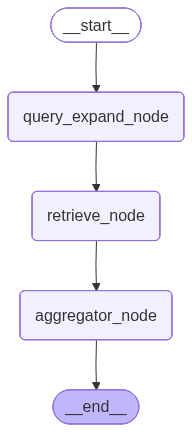

In [26]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
query = "Can i get a table for my kid, a watch for me and a laptop for my wife?"
initial_state = {
    "initial_query": query
}

In [28]:
result = graph.invoke(initial_state)

In [29]:
result

{'expanded_query': ['table for kids', 'watch for adults', 'laptop for adults'],
 'retrieved_context': ['- ID: B0C3XYD574, rating: 4.4, description: ROWT Tablet for Kids 10 inch Kids Tablet 2GB RAM 32GB ROM Android 11 6000mAh Wi-Fi, Bluetooth, Kid-Proof Case(Blue) 【Kids\' Safety & Parental Controls】Looking for a safe tablet that\'s easy for your kids to use? This 10-inch tablet for kids is GMS-certified, has password protection, a content filter, and a one-button lock screen, making it easier for parents to keep an eye on their kids activities and learning. 【Creative Educational Content】Our kids tablet provides access to a range of age-appropriate creative kids content such as drawing, educational games, eBooks, learning videos, math tools, and much more! Learning through play is best for kids to understand the world. 【Powerful Configuration & Full Access to Google】This Android 11 kids tablet has an HD 1280x800 IPS touchscreen, 1.6 GHz Quad-Core processor, 2GB RAM & 32GB ROM storage, du

In [30]:
print(result['answer'])

The available product is the Apple iPhone 14 Pro Max 256GB. Here are its detailed specifications:

- Model: Apple iPhone 14 Pro Max
- Storage Capacity: 256GB
- Color: Deep Purple
- Display: 6.7-inch Super Retina XDR display
- Processor: A16 Bionic chip
- Camera: Pro camera system with 48MP main camera, ultra-wide, and telephoto lenses
- Battery Life: Up to 29 hours video playback
- Operating System: iOS
- Additional Features: ProMotion technology with adaptive refresh rate up to 120Hz, Ceramic Shield front cover, 5G capable, Face ID for secure authentication

This model offers a large storage capacity suitable for extensive app usage, media storage, and high-quality photography.


#### Query Expansion Parallel Execution

In [64]:
class State(BaseModel):
    expanded_query: List[str] = []
    retrieved_context: Annotated[List[str], add] = []
    initial_query: str = ""
    answer: str = ""
    query: str = ""
    k: int = 10

#### Query Expansion /Rewriting Node

In [65]:
class QueryExpandResponse(BaseModel):
    expanded_query: List[str]

In [66]:
@traceable(
    name="query_expand_node",
    run_type = "llm",
    metadata = {"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def query_expand_node(state: State) ->dict:
    prompt_template = """You are part of a shopping assistant that can answer questions about products in stock.
    
    Instructions:
    -You will be given a question and you need to expand it into a list of statements that can be used in contextual search to retrieve relevant products.
    -The statements should not overlap in context.
    -Be as concise as possible, do not make up synonyms for statements, one statement per piece of context.

    <Question>
    {{ query }}
    </Question>
    """

    template = Template(prompt_template)

    prompt = template.render(
        query = state.initial_query
    )

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model = "gpt-4.1-mini",
        response_model = QueryExpandResponse,
        messages= [{"role": "system", "content": prompt}],
        temperature = 0.5
    )

    return {
        "expanded_query": response.expanded_query
    }

In [68]:
def query_expand_conditional_edges(state:State):
    send_messages = []

    for query in state.expanded_query:
        send_messages.append(
            Send(
            "retrieve_node",
            {
                "query": query,
                "k":10
            }
        )
    )
    return send_messages
        

#### Retriever Node

In [69]:
@traceable(
    name="embed_query",
    run_type = "embedding",
    metadata = {"ls_provider": "openai", "ls_model_name": "text-embedding-3-small"}
)
def get_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=text,
        model=model,
    )

    return response.data[0].embedding

@traceable(
    name="retrieve_top_n",
    run_type = "retriever",
   
)
def retrieve_node(state:State,  k=5):
    qdrant_client = QdrantClient(url="http://localhost:6333")

    query_embedding = get_embedding(state["query"])

    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-02-hybrid-search",
        prefetch = [
            Prefetch(
                query= query_embedding,
                using = "text-embedding-3-small",
                limit=20
            ),
            Prefetch(
                query=Document(
                    text=query,
                    model="qdrant/bm25"
                ),
                using = "bm25",
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=state["k"],
    )

    retrieved_context_ids = []
    retrieved_context = []
    similarity_scores = []
    retrieved_context_ratings = []

    for result in results.points:
        retrieved_context_ids.append(result.payload["parent_asin"])
        retrieved_context.append(result.payload["description"])
        retrieved_context_ratings.append(result.payload["average_rating"])
        similarity_scores.append(result.score)

    formatted_context = ""

    for id, chunk, rating in zip(retrieved_context_ids, retrieved_context, retrieved_context_ratings):
        formatted_context += f"- ID: {id}, rating: {rating}, description: {chunk}\n"


    return {
        "retrieved_context": [formatted_context]
    }

    


Aggregator Node

In [70]:
class AggregatorResponse(BaseModel):
    answer: str = Field(description="Answer to the question")

In [71]:
@traceable(
    name="aggregator_node",
    run_type = "llm",
    metadata = {"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def aggregator_node(state: State) ->dict:

    preprocessed_context = "\n".join(state.retrieved_context)
    prompt_template = f"""You are  a shopping assistant that can answer questions about products in stock.
    
    Instructions:
    -You need to answer the question based on the provided context only.
   -Never used word context and refer to it as the available products.
   -The answer to the question should contain detailed information about the product and returned with detailed specification in bullet points.

   Context:

   {{ preprocessed_context }}

    Question:
    {{ query }}
    """

    template = Template(prompt_template)

    prompt = template.render(
        preprocessed_context = preprocessed_context,
        query = state.initial_query
    )

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model = "gpt-4.1-mini",
        response_model = AggregatorResponse,
        messages= [{"role": "system", "content": prompt}],
        temperature = 0.5
    )

    return {
        "answer": response.answer
    }

#### Graph

In [72]:
workflow = StateGraph(State)

workflow.add_node("query_expand_node", query_expand_node)
workflow.add_node("retrieve_node", retrieve_node)
workflow.add_node("aggregator_node", aggregator_node)

workflow.add_edge(START, "query_expand_node")
workflow.add_conditional_edges("query_expand_node", query_expand_conditional_edges)

workflow.add_edge( "retrieve_node", "aggregator_node")
workflow.add_edge("aggregator_node", END)



graph = workflow.compile()

In [73]:
workflow = StateGraph(State)

workflow.add_node("query_expand_node", query_expand_node)
workflow.add_node("retrieve_node", retrieve_node)
workflow.add_node("aggregator_node", aggregator_node)

workflow.add_edge(START, "query_expand_node")
workflow.add_conditional_edges("query_expand_node", query_expand_conditional_edges)

workflow.add_edge("retrieve_node", "aggregator_node")
workflow.add_edge("aggregator_node", END)

graph = workflow.compile()

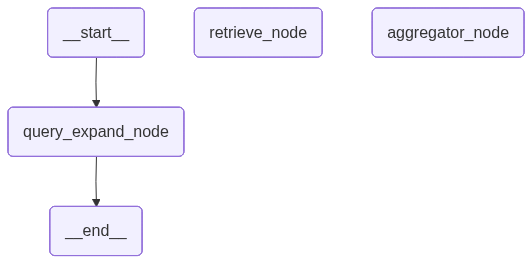

In [74]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [75]:
query = "Can I get a table for my kid, a watch for me and a laptop for my wife?"
initial_state = {
    "initial_query": query
}

In [76]:
result = graph.invoke(initial_state)

In [77]:
result

{'expanded_query': ['table for kid', 'watch for adult', 'laptop for wife'],
 'retrieved_context': ['- ID: B0C3XYD574, rating: 4.4, description: ROWT Tablet for Kids 10 inch Kids Tablet 2GB RAM 32GB ROM Android 11 6000mAh Wi-Fi, Bluetooth, Kid-Proof Case(Blue) 【Kids\' Safety & Parental Controls】Looking for a safe tablet that\'s easy for your kids to use? This 10-inch tablet for kids is GMS-certified, has password protection, a content filter, and a one-button lock screen, making it easier for parents to keep an eye on their kids activities and learning. 【Creative Educational Content】Our kids tablet provides access to a range of age-appropriate creative kids content such as drawing, educational games, eBooks, learning videos, math tools, and much more! Learning through play is best for kids to understand the world. 【Powerful Configuration & Full Access to Google】This Android 11 kids tablet has an HD 1280x800 IPS touchscreen, 1.6 GHz Quad-Core processor, 2GB RAM & 32GB ROM storage, dual c

In [78]:
print(result['answer'])

The product available is a Smart TV with the following detailed specifications:

- Screen Size: 55 inches
- Resolution: 4K Ultra HD
- Brand: Samsung
- Connectivity: Wi-Fi and Bluetooth enabled
- Additional Features: HDR support, Smart Hub for apps and streaming
- Ports: Multiple HDMI and USB ports
- Sound: Built-in speakers with Dolby Digital Plus

This Smart TV offers a high-resolution viewing experience with advanced connectivity options and smart features for entertainment.
